In [11]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
from sklearn.datasets import make_regression

def nonlinear_data(m=100, n=3, seed=0):
    """ Toy data for testing """
    X, _ = make_regression(
        n_samples=m, 
        n_features=n, 
        n_informative=1,
        noise=3.5,
        random_state=seed,
    )
    rng = np.random.RandomState(seed)
    X[:, 0] = np.sort(6 * rng.rand(m, 1) - 3, axis=0).reshape(m,)
    y = (2 + .5* X[:, 0]**2 + X[:, 0]) + rng.rand(m)

    return X, y.reshape(-1, 1)

In [13]:
bike_df = pd.read_csv("train.csv")

In [17]:
bike_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


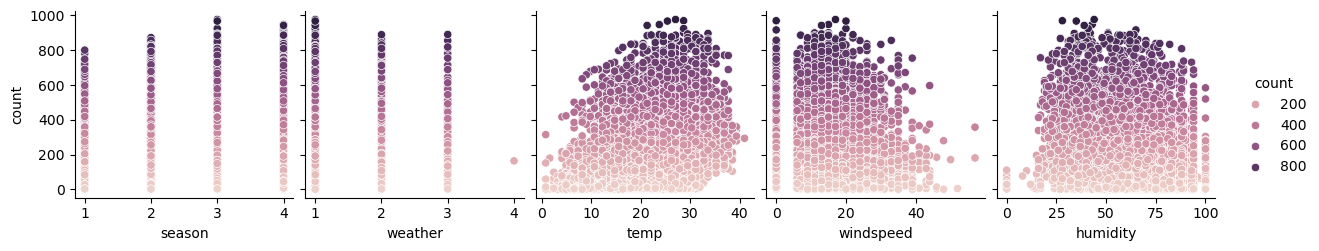

In [22]:
import seaborn as sb
rng = np.random.RandomState(1)
indices = rng.choice(np.arange(len(bike_df)), size = len(bike_df), replace=False)

sb.pairplot(
    bike_df.iloc[indices],
    x_vars=["season","weather", "temp", "windspeed", "humidity",],
    y_vars=["count",],
    hue="count",
)
plt.show()

In [36]:
from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [38]:
def get_preprocessed_data() -> Tuple[np.ndarray, ...]:
    """ Gets preprocessed data for training, validation, and testing

        Return:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst= None, None, None, None, None, None
    # TODO 2.1 - 2.3
    from sklearn.preprocessing import StandardScaler
    
    X = bike_df.drop(['count', 'datetime'], axis=1).values
    y = bike_df['count'].values
    
    # Split the data into training, validation, and testing sets
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)
    
    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)



    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

In [40]:
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse

In [42]:
class Linear():
    """ The linear or identity actionvation function """
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        """ Computes the output of the linear activation function """
        # TODO 3.1
        
        return z
    
    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        """ Computes the derivative for the linear activation function """
        # TODO 3.2
        
        return np.ones(z.shape)

In [44]:
class Tanh():
    """ The tanh actionvation function """
    @staticmethod
    def activation(z: np.ndarray) -> np.ndarray:
        """ Computes the output of the tanh activation function """
        # TODO 4.1
        
        return np.tanh(z)

    @staticmethod
    def derivative(z: np.ndarray) -> np.ndarray:
        """ Computes the derivative of the tanh activation function """
        # TODO 4.2
        
        return 1 - np.tanh(z)**2

In [46]:
def init_weights(
    n_input_features: int, 
    hidden_neurons: int, 
    output_neurons: int, 
) -> Tuple[np.ndarray, ...]:
    """ Initilize the hidden and output layer parameters
        
        Args:
            n_input_features: The number of input features

            hidden_neurons: The number of hidden neurons or units to 
                use in the hidden layer.

            output_neurons: The number of output neurons to use in 
                the output layer.

        Returns:
            A tuple of NumPy arrays containing the weights and biases
            for the hidden and output layers.
    """
    # TODO 5
    W1, b1, W2, b2 = np.random.uniform(-0.5, 0.5, size=(n_input_features, hidden_neurons)), np.ones((1, hidden_neurons)), np.random.uniform(-0.5, 0.5, size=(hidden_neurons, output_neurons)), np.ones((1, output_neurons))
    
    return W1, b1, W2, b2

In [48]:
def forward(
    X: np.ndarray, 
    W1: np.ndarray, 
    b1: np.ndarray,
    W2: np.ndarray, 
    b2: np.ndarray, 
) -> Tuple[np.ndarray, ...]:
    """ Forward pass for 2 layer neural network
    
        Args:
            X: Input features
            
            W1: Hidden layer weights 
            
            b1: Hidden layer baises

            W2: Output layer weights 
            
            b2: Output layer baises

        Returns:
            A tuple of NumPy arrays containing the linear combination and 
            acitvation outputs for each layer. These are needed to compute 
            the backward pass.
    """
    Z1, A1, Z2, A2 = None, None, None, None
    # TODO 6
    Z1 = np.dot(X, W1) + b1
    A1 = Tanh.activation(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = Linear.activation(Z2)
    return Z1, A1, Z2, A2

In [50]:
def output_layer_grads(
    X: np.ndarray,
    y: np.ndarray,
    W1: np.ndarray,
    Z1: np.ndarray,
    A1: np.ndarray,
    W2: np.ndarray,
    Z2: np.ndarray,
    A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """ Compute gradients for the output layer parameters
        
        Note:
            You might not use all the passed arguments!
    
        Args:
            X: Input data given as a matrix
            
            y: Ground truth labels given as a column vector

            W1: Hidden layer weights
            
            Z1: Linear combination output for hidden layer

            A1: Activation output for hidden layer
            
            W2: Output layer weights

            Z2: Linear combination output for the output layer

            A2: Activation output or the output layer. Also 
                referred to as y_hat.
            
        Return:
            A tuple of NumPy arrays containing the average gradient 
            for the output layer weights and biases.
    """
    # TODO 7
    W2_avg_grad, b2_avg_grad = None, None
    
    m = y.shape[0] 

    dZ2 = A2 - y
    
    W2_avg_grad = np.dot(A1.T, dZ2) / m
    b2_avg_grad = np.sum(dZ2, axis=0, keepdims=True) / m

    return W2_avg_grad, b2_avg_grad

In [52]:
def hidden_layer_grads(
    X: np.ndarray,
    y: np.ndarray,
    W1: np.ndarray,
    Z1: np.ndarray,
    A1: np.ndarray,
    W2: np.ndarray,
    Z2: np.ndarray,
    A2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """ Compute gradients for the hidden layer parameters
        
        Note:
            You might not use all the passed arguments!
    
        Args:
            X: Input data given as a matrix
            
            y: Ground truth labels given as a column vector

            W1: Hidden layer weights
            
            Z1: Linear combination output for hidden layer

            A1: Activation output for hidden layer
            
            W2: Output layer weights

            Z2: Linear combination output for the output layer

            A2: Activation output or the output layer. Also 
                referred to as y_hat.
            
        Return:
            A tuple of NumPy arrays containing the average gradient 
            for the hidden layer weights and biases.
    """
    # TODO 8
    W1_avg_grad, b1_avg_grad = None, None

    m = y.shape[0] 
    
    dZ2 = A2 - y
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (1 - np.tanh(Z1)**2)  
    
    W1_avg_grad = np.dot(X.T, dZ1) / m
    b1_avg_grad = np.sum(dZ1, axis=0, keepdims=True) / m

    return W1_avg_grad, b1_avg_grad

In [54]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:
    """ Generates mini-batches based on the data indexes
        
        Args:
            data_len: Length of the data or number of data samples 
                in the data. This is used to generate the indices of
                the data.
            
            batch_size: Size of each mini-batch where the last mini-batch
                might be smaller than the rest if the batch_size does not 
                evenly divide the data length.

        Returns:
            A list of NumPy array's holding the indices of batches
    """
    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [56]:
class NeuralNetwork():
    def __init__(self,
        hidden_neurons: int,
        output_neurons: int,
        alpha: float, 
        batch_size: int,
        epochs: int = 1,
        seed: int = 0,
    ):
        """ A two layer neural network using SGD
            
            Attributes:
                hidden_neurons: Number of hidden units/neurons.
                
                output_neurons: Number of output neuorns
                
                alpha: learning rate or step size.
                
                batch_size: Size of mini-batches for mini-batch gradient
                    descent.
                
                epochs: Number of epochs to run for mini-batch
                    gradient descent.
                    
                seed: Seed to be used for NumPy's RandomState class
                    or universal seed np.random.seed() function.
    
                W1: Hidden layer weights with shape (inputs, neurons)
                
                b1: Hidden layer baises with shape (1, neurons)
                
                W2: Output layer weights with shape (inputs, neurons)
                
                b2: Output layer baises with shape (1, neurons)
    
                trn_error: Stores the training error for each epoch.
    
                vld_error: Stores the validation error for each epoch.
        """
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.batch_size = batch_size
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed
        
        self.W1, self.b1 = None, None
        self.W2, self.b2 = None, None
        self.trn_error = None
        self.vld_error = None

    def fit(
        self,
        X: np.ndarray, 
        y: np.ndarray,
        X_vld: np.ndarray = None, 
        y_vld:np.ndarray = None,
    ): 
        """ Trains a basic two layer neural network using SGD
        
            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector

                X_vld: Validation data given as a 2D matrix. Used 
                    to compute the validation RMSE for each epoch.

                y_vld: Validation labels given as a 2D matrix. Used 
                    to compute the validation RMSE for each epoch.
                
            Returns:
                The class's own object reference. 
        """
        np.random.seed(self.seed)
        self.trn_error = []
        self.vld_error = []
        
        # TODO 9.1
        self.W1, self.b1, self.W2, self.b2 = init_weights(n_input_features=X.shape[1],hidden_neurons=self.hidden_neurons,output_neurons=self.output_neurons)
        n_inputs = X.shape[1]
        for e in range(self.epochs):
            batches = get_batches(len(X), batch_size=self.batch_size)
            for b in batches:
                X_b= X[b]
                y_b = y[b]
                Z1, A1, Z2, A2 = forward(X_b, self.W1, self.b1, self.W2, self.b2)
    
                dZ2 = A2 - y_b
                dW2 = np.dot(A1.T, dZ2) / len(X_b)
                db2 = np.sum(dZ2, axis=0, keepdims=True) / len(X_b)
                dW1, db1 = hidden_layer_grads(X_b, y_b, self.W1, Z1, A1, self.W2, Z2, A2)
                    
                self.W2 -= self.alpha * dW2
                self.b2 -= self.alpha * db2
                self.W1 -= self.alpha * dW1
                self.b1 -= self.alpha * db1
            
            y_pred = self.predict(X)
            train_rmse = mse(y, y_pred)  
            self.trn_error.append(train_rmse)
            
            if X_vld is not None and y_vld is not None:
                y_vld_pred = self.predict(X_vld)
                val_rmse = mse(y_vld, y_vld_pred)  # RMSE
                self.vld_error.append(val_rmse)
        
        return self
        
        
    
    def predict(self, X: np.ndarray):
        """ Make predictions using forward pass.

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        # TODO 9.2
        
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = np.tanh(Z1)
        Z2 = np.dot(A1, self.W2) + self.b2
        return Z2

In [257]:
X_train, y_train, X_vld, y_vld, X_test, y_test = get_preprocessed_data()

X = bike_df.drop(['count', 'datetime'], axis=1).values
y = bike_df['count'].values

nn = NeuralNetwork(
    hidden_neurons=500,
    output_neurons=1,
    batch_size=42,
    alpha=0.01,
    epochs=500,
    seed=42,
)

nn.fit(X_train, y_train, X_vld, y_vld)

Train MSE: 0.711032186826368
Validation MSE: 2.166352134229816


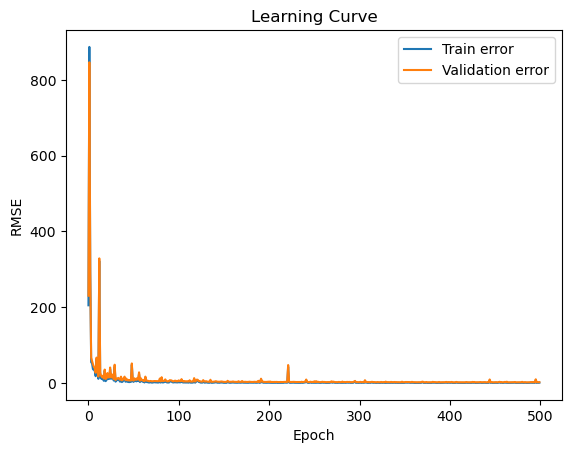

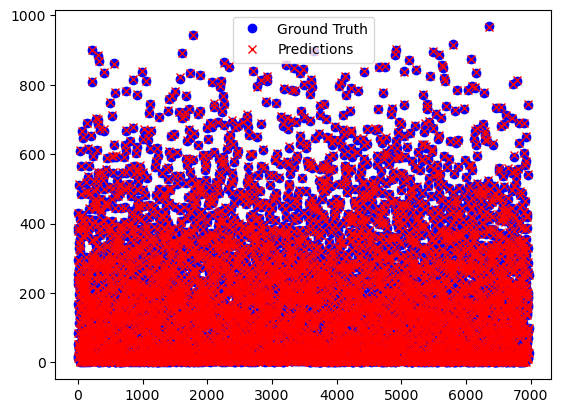

In [274]:
nn.fit(X_train, y_train, X_vld=X_vld, y_vld=y_vld)
y_hat_trn = nn.predict(X_train)
trn_mse_score = mse(y_train, y_hat_trn)
print(f"Train MSE: {trn_mse_score}")
y_hat_vld = nn.predict(X_vld)
vld_mse_score = mse(y_vld, y_hat_vld)
print(f"Validation MSE: {vld_mse_score}")

plt.plot(nn.trn_error, label='Train error')
plt.plot(nn.vld_error, label='Validation error')
plt.title("Learning Curve")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(y_train, 'ob', label='Ground Truth')
plt.plot(nn.predict(X_train), 'xr', label='Predictions')
plt.legend()
plt.show()